In [2]:
import numpy as np
from datasets import load_dataset


# Load the dataset with the `large_random_1k` subset
dataset = load_dataset('poloclub/diffusiondb', 'large_random_1k', trust_remote_code=True)

KeyboardInterrupt: 

In [1]:
from urllib.request import urlretrieve
import pandas as pd

# Download the parquet table
table_url = f'https://huggingface.co/datasets/poloclub/diffusiondb/resolve/main/metadata.parquet'
urlretrieve(table_url, 'metadata.parquet')

# Read the table using Pandas
metadata_df = pd.read_parquet('metadata.parquet')

In [2]:
# get image "de640f9c-2968-4a80-9020-4bb905b9bb52.png" from metadata_df
image_name = "de640f9c-2968-4a80-9020-4bb905b9bb52.png"
image_row = metadata_df[metadata_df['image_name'] == image_name]
len(image_row['prompt'].values[0])

11

In [3]:
metadata_df.head()

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
0,2217ccbd-a1c6-47ac-9a2d-79649727c834.png,"a portrait of a female robot made from code, v...",1,2615452544,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:56:00+00:00,0.554853,0.001621
1,c78807b7-d55a-4a2d-a6b6-9192b18941ad.png,a portrait of a female robot made from a cloud...,1,4231506957,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 11:59:00+00:00,0.153645,0.000707
2,dc71658a-5e4b-4dca-861a-e1535510348b.png,"only memories remain, trending on artstation",1,544607824,50,7.0,8,512,512,0167cc490c3dc6047be855b096a9b9d8f20e2b034532bd...,2022-08-20 12:02:00+00:00,0.062496,0.000425
3,48eb7e17-a3cf-4eb8-96a9-d8e3e23fa1af.png,dream swimming pool with nobody,1,3500509234,50,7.0,8,512,512,019084defdd44d2dfcd200bf7aaae53034263168e10d6b...,2022-08-20 07:22:00+00:00,0.030799,0.003586
4,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,2022-08-20 12:28:00+00:00,0.181035,0.030822


In [4]:
# print all unique parts in the parts column
print(metadata_df['part_id'].unique())
def word_count(prompt):
    return len(prompt.split())

[   1    2    3 ... 1998 1999 2000]


<Axes: title={'center': 'Histogram of Prompt Lengths'}, ylabel='Frequency'>

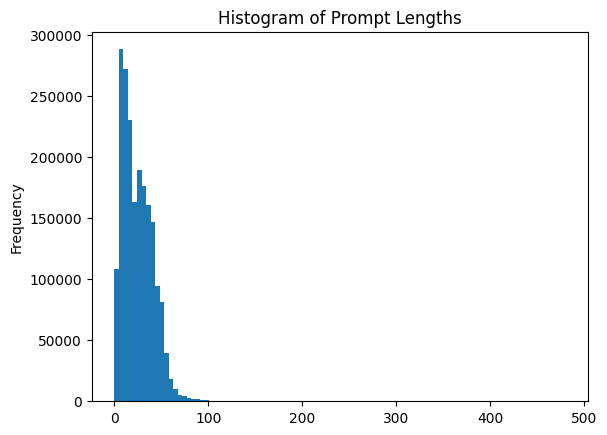

In [5]:
# metadata_df["prompt"]
metadata_df["prompt_length"] = metadata_df["prompt"].apply(word_count)
metadata_df["prompt_length"].plot(kind='hist', bins=100, title='Histogram of Prompt Lengths')

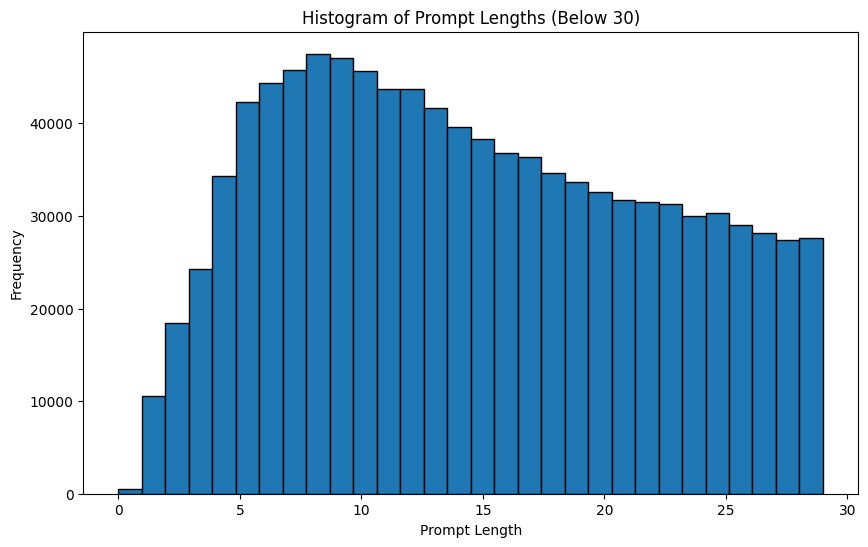

In [6]:
import matplotlib.pyplot as plt

# Filter the dataframe to include only prompts with length below 30
filtered_df = metadata_df[metadata_df['prompt_length'] < 30]
# Filter the dataframe for images with image NSFW and prompt NSFW scores lower than 0.2
filtered_nsfw_df = filtered_df[(filtered_df['image_nsfw'] < 0.2) & (filtered_df['prompt_nsfw'] < 0.2)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_nsfw_df['prompt_length'], bins=30, edgecolor='black')
plt.title('Histogram of Prompt Lengths (Below 30)')
plt.xlabel('Prompt Length')
plt.ylabel('Frequency')
plt.show()

1008775 833563


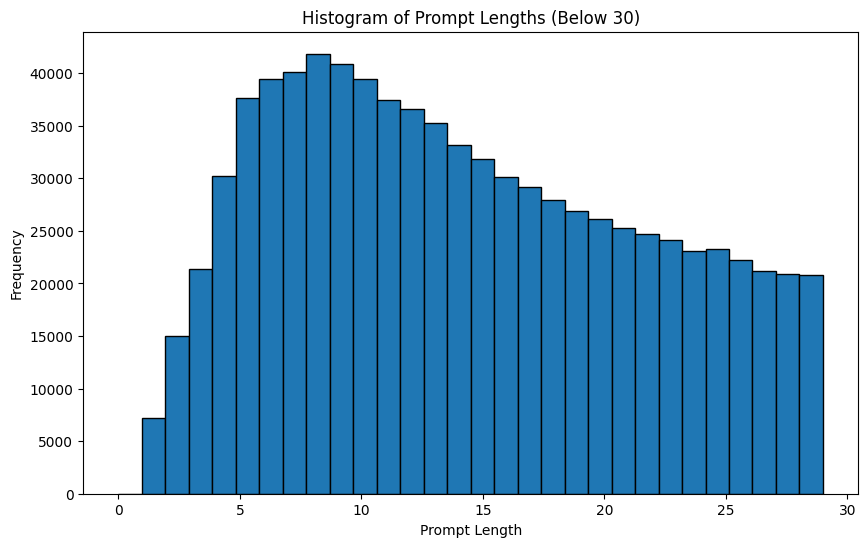

In [7]:
# filter the dataframe to remove dups in the prompt column, save the duplicate with the highest cfg score
filtered_df = filtered_nsfw_df.sort_values('cfg', ascending=False).drop_duplicates('prompt').sort_index()
print(len(filtered_nsfw_df), len(filtered_df))
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['prompt_length'], bins=30, edgecolor='black')
plt.title('Histogram of Prompt Lengths (Below 30)')
plt.xlabel('Prompt Length')
plt.ylabel('Frequency')
plt.show()

In [8]:
filtered_nsfw_df = filtered_df
filtered_nsfw_df_pre_cfg = filtered_nsfw_df

count    833563.000000
mean          8.395198
std         196.231216
min      -10000.000000
25%           7.000000
50%           7.000000
75%           7.000000
max      100000.000000
Name: cfg, dtype: float64
count    112956.000000
mean         12.197826
std           3.167848
min           8.000000
25%          10.000000
50%          12.000000
75%          15.000000
max          20.000000
Name: cfg, dtype: float64


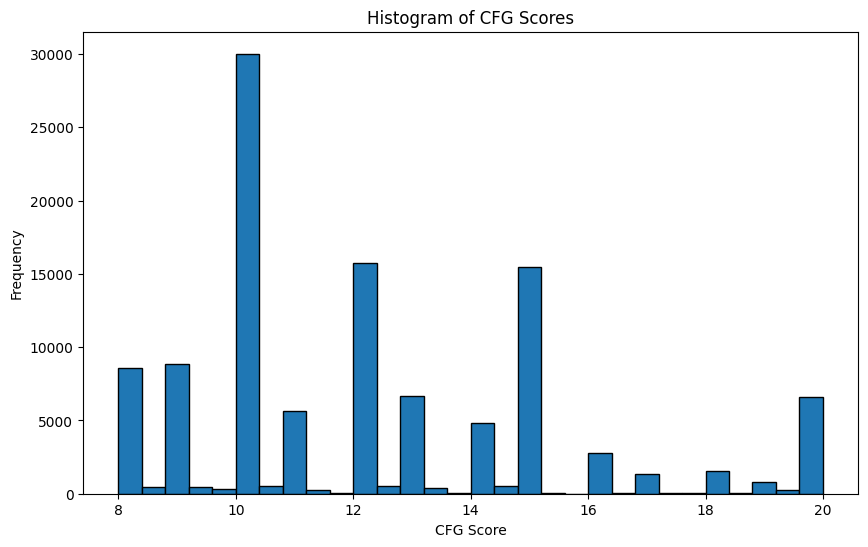

In [9]:
# plot cfg score of the images in the filtered_nsfw_df
print(filtered_nsfw_df['cfg'].describe())
# only take the images with cfg score between 0 and 20
filtered_nsfw_df = filtered_nsfw_df[(filtered_nsfw_df['cfg'] >= 8) & (filtered_nsfw_df['cfg'] <= 20)]
print(filtered_nsfw_df['cfg'].describe())


plt.figure(figsize=(10, 6))
plt.hist(filtered_nsfw_df['cfg'], bins=30, edgecolor='black')
plt.title('Histogram of CFG Scores')
plt.xlabel('CFG Score')
plt.ylabel('Frequency')
plt.show()



In [10]:

# show the part_ids which contains the most images with promplength between 4 and 20
most_common_part_ids = filtered_nsfw_df[filtered_nsfw_df['prompt_length'].between(4, 20)]['part_id'].value_counts().head()
print(most_common_part_ids)

part_id
305     188
1534    143
1655    140
1239    132
1719    129
Name: count, dtype: int64


In [11]:
# # filter by sampler - only take DDIM and Euler samplers, which are 1, 4 and 5 
# filtered_nsfw_df = filtered_nsfw_df[filtered_nsfw_df['sampler'].isin([1, 4, 5])]
# print(filtered_nsfw_df['sampler'].value_counts())




In [12]:
# save only the prompts to a file, indexed by image name
filtered_nsfw_df[['image_name', 'prompt']].to_csv('prompts.csv', index=False)


In [17]:
# read result_df from csv 
result_df = pd.read_csv('prompts_filtered.csv')
print(len(result_df))
result_df.head()


71820


,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,prompt_length
0,601d9792-eccd-4850-97a7-edbe91d3464c.png,a dog doing weights. epic oil painting.,1,1312381211,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,2022-08-20 12:28:00+00:00,0.181035,0.030822,7
1,a5ec307e-7e7b-4740-ad70-9bdb6f417bd1.png,yoji shinkawa painting of a stylish sniper demon,1,2038333716,50,12.0,8,512,768,03cb377ebf364ea2761b5710625974c0d2d25285fec982...,2022-08-20 12:34:00+00:00,0.078747,0.029799,8
2,8a51dbc0-73fd-4a42-9304-4ea0875cf907.png,"a very drunk person named aaron, sharp focus, ...",1,1602144611,50,10.0,8,704,512,09f626452626d3160635d5701406375e263939584f48af...,2022-08-20 06:46:00+00:00,0.025164,0.130819,16
3,7f900636-982d-46a4-977b-7fe64b944d17.png,"book cover illustration, art by gerald brom, o...",1,3601922926,50,14.5,8,640,512,0c763dc0d94f5dc846868fdf51724dba283ca9ae3daa6c...,2022-08-20 11:43:00+00:00,0.122356,0.000775,29
4,1e88df35-4ac6-4350-bb32-41c09a22d7a4.png,"geodesic dreams of buckminster fuller, by arts...",1,3529786060,50,10.0,8,896,512,0cffabb468fc6047499fb5f498012d24c984b113f22681...,2022-08-20 12:01:00+00:00,0.160753,0.002423,17


In [ ]:
import difflib
import re

# A simple regex to detect patterns like "by Firstname Lastname"
# This pattern looks for " by " followed by two words that start with uppercase letters.
name_pattern = re.compile(r'\bby\s+([A-Z][a-z]+(?:\s+[A-Z][a-z]+)+)\b')

def contains_person_name(prompt):
    # Check if the prompt matches the regex.
    # You might want to expand this function to catch additional patterns.
    # add filter for "art by x y"
    return " by " in prompt # if by is in prompt it is probably art by someone or painitng by someone 
    # return bool(name_pattern.search(prompt))

# Filter out prompts that contain people's names
df_filtered = filtered_nsfw_df[~filtered_nsfw_df['prompt'].apply(contains_person_name)].copy()

# Remove near-duplicate prompts
filtered_rows = []
accepted_prompts = []

similarity_threshold = 0.85  # Adjust threshold if needed
window_size = 3            # Check only the previous 100 rows.

# List to store indices of accepted prompts.
accepted_indices = []

# Iterate through the filtered DataFrame.
for i in range(len(df_filtered)):
    current_prompt = df_filtered.iloc[i]['prompt']
    is_duplicate = False
    # Determine the start index for the sliding window.
    start_idx = max(0, i - window_size)
    # Compare with prompts in the preceding window.
    for j in range(start_idx, i):
        previous_prompt = df_filtered.iloc[j]['prompt']
        sim = difflib.SequenceMatcher(None, current_prompt, previous_prompt).ratio()
        if sim >= similarity_threshold:
            is_duplicate = True
            break
    if not is_duplicate:
        accepted_indices.append(i)
    if i % 1000 == 0:
        print(f"Processed {i} out of {len(df_filtered)} prompts.")
    
# Create a new DataFrame with the filtered rows.
result_df = df_filtered.iloc[accepted_indices]

# # Optionally, save the filtered CSV to a new file.
result_df.to_csv('prompts_filtered.csv', index=False)

print("Filtering complete. Filtered CSV saved to '/mnt/data/prompts_filtered.csv'")

Processed 0 out of 107817 prompts.
Processed 1000 out of 107817 prompts.
Processed 2000 out of 107817 prompts.
Processed 3000 out of 107817 prompts.
Processed 4000 out of 107817 prompts.
Processed 5000 out of 107817 prompts.
Processed 6000 out of 107817 prompts.
Processed 7000 out of 107817 prompts.
Processed 8000 out of 107817 prompts.
Processed 9000 out of 107817 prompts.
Processed 10000 out of 107817 prompts.
Processed 11000 out of 107817 prompts.
Processed 12000 out of 107817 prompts.
Processed 13000 out of 107817 prompts.
Processed 14000 out of 107817 prompts.
Processed 15000 out of 107817 prompts.
Processed 16000 out of 107817 prompts.
Processed 17000 out of 107817 prompts.
Processed 18000 out of 107817 prompts.
Processed 19000 out of 107817 prompts.
Processed 20000 out of 107817 prompts.
Processed 21000 out of 107817 prompts.
Processed 22000 out of 107817 prompts.
Processed 23000 out of 107817 prompts.
Processed 24000 out of 107817 prompts.
Processed 25000 out of 107817 prompts.

In [ ]:
# TOODO: There are still people names in this, maybe use some AI model to filter them, this might take some time rn not prioritiezed.

44766


In [25]:
# print(len(result_df), len(df_filtered), len(filtered_nsfw_df) )
filtered_nsfw_df_old = filtered_nsfw_df
filtered_nsfw_df = result_df

In [26]:
easy_images = filtered_nsfw_df[(filtered_nsfw_df['prompt_length'] >= 4) & (filtered_nsfw_df['prompt_length'] <= 8)]
medium_images = filtered_nsfw_df[(filtered_nsfw_df['prompt_length'] > 8) & (filtered_nsfw_df['prompt_length'] <= 12)]
hard_images = filtered_nsfw_df[(filtered_nsfw_df['prompt_length'] > 12) & (filtered_nsfw_df['prompt_length'] <= 20)]
print(f'Easy images: {easy_images.shape[0]}, Medium images: {len(medium_images)}, Hard images: {len(hard_images)}')

Easy images: 7308, Medium images: 8022, Hard images: 14609


In [28]:

# show most common part id for each difficulty level
print(easy_images['part_id'].value_counts().head())
print(medium_images['part_id'].value_counts().head())
print(hard_images['part_id'].value_counts().head())


part_id
1609    24
306     22
1648    22
650     21
844     20
Name: count, dtype: int64
part_id
1534    83
1199    28
1850    25
12      20
1533    19
Name: count, dtype: int64
part_id
687     36
1050    35
910     33
856     26
733     26
Name: count, dtype: int64


In [30]:
import os
IMAGES_PATH = "diffusiondb/images"
def get_available_parts():
    parts_ids = [int(i[len('part-'):]) for i in os.listdir(IMAGES_PATH)]
    return parts_ids
parts_ids = get_available_parts()
print(parts_ids)

[51, 450, 1219, 1534, 1609, 1655, 1816]


In [38]:
def get_good_length_images_from_part(images_df,lower_bound, upper_bound, part_id, n_images=10):
    # Filter the images by part_id
    part_images = images_df[images_df['part_id'] == part_id]
    
    # Filter the images by prompt length
    filtered_images = part_images[part_images['prompt_length'].between(lower_bound, upper_bound)]
    
    # Select the first n_images
    selected_images = filtered_images.head(n_images)
    
    return selected_images

def get_available_length_images(images_df,lower_bound, upper_bound, n_images=0):
    parts = get_available_parts()

    # Filter the images by part_id
    part_images = images_df[images_df['part_id'].isin(parts)]

    # Filter the images by prompt length
    filtered_images = part_images[part_images['prompt_length'].between(lower_bound, upper_bound)]
    
    # Select the first n_images
    if n_images != 0:
        selected_images = filtered_images.head(n_images)
    else:
        selected_images = filtered_images
    return selected_images

In [39]:

# Combine the dataframes
# selected_data = pd.concat([get_good_length_images_from_part(filtered_nsfw_df, 4, 10, 51, n_images=20), get_good_length_images_from_part(filtered_nsfw_df, 10, 20, 51, n_images=20)])
selected_data = pd.concat([get_available_length_images(result_df, 4, 8, n_images=20), get_available_length_images(result_df, 8, 15, n_images=20),
                           get_available_length_images(result_df, 15, 20, n_images=20)])
selected_data_full = pd.concat([get_available_length_images(result_df, 4, 8), get_available_length_images(result_df, 8, 15),
                           get_available_length_images(result_df, 15, 20)])
print(len(selected_data), len(selected_data_full))  

60 300


In [55]:
img = metadata_df[metadata_df['image_name'] == '00dd0418-d339-4833-9d5d-fd6a01087193.webp']
img

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,prompt_length


In [43]:
img = result_df[result_df['image_name'] == 'e63e2d9f-1545-4a55-99dd-02fe99559a45.png']
img

,image_name,prompt,part_id,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw,prompt_length
14766,e63e2d9f-1545-4a55-99dd-02fe99559a45.png,a mammoth trying a new dress,450,3838470372,50,10.0,8,512,512,9ea2260cbb9acca5574cf6c9252348d9c23bd611632efe...,2022-08-15 23:28:00+00:00,0.088061,0.153718,6


In [56]:
import os
import shutil

# images are stored at "/data/part-{index:06}/image_name" copy each image in the selected images to a the folder /data/selected_images and save selected_images as file in /data/selected_images.csv
# Create the destination directory if it doesn't exist
destination_dir = 'data/selected_images'
os.makedirs(destination_dir, exist_ok=True)
j = 0
# Copy each selected image to the destination directory
for index, image in selected_data.iterrows():
    part_id = image['part_id']
    source_path = f'{IMAGES_PATH}/part-{part_id:06}/{image["image_name"]}'
    destination_path = os.path.join(destination_dir, image['image_name'])
    # print(index, source_path, destination_path)
    try:
        shutil.copy(source_path, destination_path)
        print(f"Image {image['image_name']} in part {image['part_id']} copied successfully.")
    except FileNotFoundError:
        j+=1
        print(f"File {source_path} innot found. {j}")
# Save the selected images to a CSV file
selected_data.to_csv('data/selected_images.csv', index=False)

Image 1ac4d547-7794-497e-a1ed-3923589cda6a.png in part 51 copied successfully.
Image a827e12e-c6d6-416d-af6a-0a85460cefba.png in part 51 copied successfully.
Image dc73a1a1-1be0-464c-8fb9-d507d0f052a6.png in part 51 copied successfully.
Image e63e2d9f-1545-4a55-99dd-02fe99559a45.png in part 450 copied successfully.
Image 91f1f0ab-0fc2-474f-b3ec-a265cc9f2a4a.png in part 450 copied successfully.
Image 2323987b-cc0a-4538-9335-95c1c7f0949a.png in part 1219 copied successfully.
Image 21d4963f-3425-492b-8f60-4b243dbb7c15.png in part 1534 copied successfully.
Image e3d2dc1a-dd8d-4600-9611-60946fb15501.png in part 1534 copied successfully.
Image 46124172-b259-4ab1-908e-e823e0335056.png in part 1534 copied successfully.
Image 97a1e231-8c2a-4d08-8229-b26c36f82022.png in part 1534 copied successfully.
Image d46cb0c2-051b-4957-a0c9-d3b5a5e73955.png in part 1534 copied successfully.
Image 848b43c7-ceec-437e-895b-44e831b7d0d6.png in part 1534 copied successfully.
Image 567b8145-7225-44cc-82de-c63f75